In [213]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy.stats import boxcox, yeojohnson
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# set seanborn style
sns.set_style("whitegrid")

- more 6days waiting for a response shows a steep drop off in quality, can we measure impact on quality? for example, when a customer waits <2days CSAT is "normal" (average at that time - no impact), between 2-6days CSAT is reduced by 2 percentage points on average (from "normal"), >6 days CSAT is reduced by 10 percentage points (from "normal")

- I hope that makes sense but would be happy to catch up and clarify further if needed. My ultimate goal here is to try to understand if we can find specific markers in wait time where we can predict/assume a specific impact on quality (CSAT).

In [214]:
csv_path = os.path.join(os.path.expanduser("~"), "Desktop", "query_result_2025-01-15T17_04_57.113316Z.csv")
df = pd.read_csv(csv_path)
df['created_date'] = df['created_date'].str.split('T').str[0]
df['created_date'] = pd.to_datetime(df['created_date'])
df

,created_date,response_id,support_satisfaction,wait_time
0,2021-10-17,0Ki5J000000fUy4SAE,1.5,16231.0
1,2021-10-17,0Ki5J000000fVOmSAM,0.5,292.0
2,2021-10-17,0Ki5J000000fVQKSA2,5.0,3092.0
3,2021-10-17,0Ki5J000000fVRkSAM,0.5,15788.0
4,2021-10-17,0Ki5J000000fVTJSA2,4.5,385.0
...,...,...,...,...
113602,2025-01-15,0Kicj000001fAirCAE,1.0,48122.0
113603,2025-01-15,0Kicj000001fBesCAE,2.0,85938.0
113604,2025-01-15,0Kicj000001fCizCAE,2.0,1078840.0
113605,2025-01-15,0Kicj000001fDn9CAE,5.0,620214.0


In [215]:
df['wait_time'] = df['wait_time'] / 86400 #in days
df.dropna(inplace=True)

# Create a categorization based on the actual number of days (1, 2, 3, ..., etc)
def label_days(actual_days):
    return f'{int(actual_days)}'
df['wait_time_in_days'] = df['wait_time'].apply(label_days)
# convert to % the support satisfaction values, so out of 5 each value should divide by 5 and multiply by 100
df['support_satisfaction_in_perc'] = df['support_satisfaction'] / 5

df

,created_date,response_id,support_satisfaction,wait_time,wait_time_in_days,support_satisfaction_in_perc
0,2021-10-17,0Ki5J000000fUy4SAE,1.5,0.187859,0,0.3
1,2021-10-17,0Ki5J000000fVOmSAM,0.5,0.003380,0,0.1
2,2021-10-17,0Ki5J000000fVQKSA2,5.0,0.035787,0,1.0
3,2021-10-17,0Ki5J000000fVRkSAM,0.5,0.182731,0,0.1
4,2021-10-17,0Ki5J000000fVTJSA2,4.5,0.004456,0,0.9
...,...,...,...,...,...,...
113602,2025-01-15,0Kicj000001fAirCAE,1.0,0.556968,0,0.2
113603,2025-01-15,0Kicj000001fBesCAE,2.0,0.994653,0,0.4
113604,2025-01-15,0Kicj000001fCizCAE,2.0,12.486574,12,0.4
113605,2025-01-15,0Kicj000001fDn9CAE,5.0,7.178403,7,1.0


In [216]:
avg_csat = df.groupby('wait_time_in_days')['support_satisfaction_in_perc'].mean().reset_index()
avg_csat.columns = ['wait_time_in_days', 'avg_csat']

# Group by created_date and wait_time_in_days together
#This is because we want to know the average CSAT for each level of wait time
grouped_df = df.groupby(['created_date', 'wait_time_in_days']).agg(
    response_id_count=('response_id', 'count'),
    avg_support_satisfaction=('support_satisfaction_in_perc', 'mean'),
    avg_wait_time=('wait_time', 'mean')).reset_index()

grouped_df = pd.merge(grouped_df, avg_csat, on='wait_time_in_days', how='left')
grouped_df

,created_date,wait_time_in_days,response_id_count,avg_support_satisfaction,avg_wait_time,avg_csat
0,2021-10-17,0,5,0.480000,0.082843,0.716801
1,2021-10-18,0,42,0.654762,0.213152,0.716801
2,2021-10-18,1,2,0.550000,1.218466,0.632573
3,2021-10-19,0,63,0.615873,0.279523,0.716801
4,2021-10-19,1,10,0.330000,1.316993,0.632573
...,...,...,...,...,...,...
8090,2025-01-15,3,6,0.333333,3.489182,0.555415
8091,2025-01-15,4,1,0.200000,4.856007,0.537262
8092,2025-01-15,5,1,0.200000,5.155521,0.525350
8093,2025-01-15,6,5,0.480000,6.440431,0.512687


### 1. Vizualization of original data (with skewness)

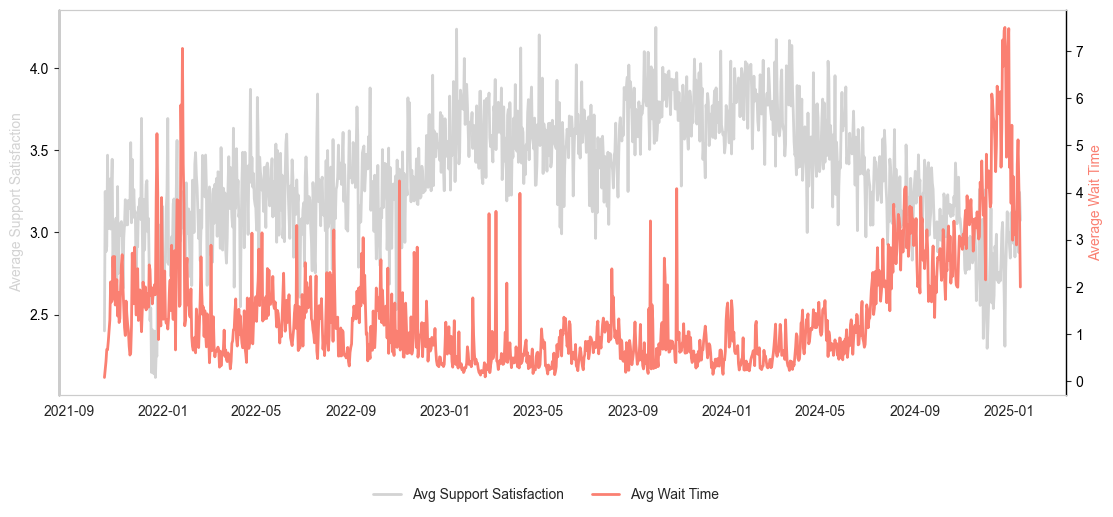

In [183]:
fig, ax1 = plt.subplots(figsize=(13, 5))

# Plot avg_support_satisfaction on the first y-axis

ax1.set_ylabel('Average Support Satisfaction', color='lightgrey', fontsize=10)
ax1.plot(grouped_df['created_date'], grouped_df['avg_support_satisfaction'], color='lightgrey', label='Avg Support Satisfaction', linewidth=2)
ax1.tick_params(axis='y', labelcolor='black')
ax1.spines['left'].set_color('black')
ax1.spines['left'].set_linewidth(1)

ax2 = ax1.twinx()
ax2.set_ylabel('Average Wait Time', color='salmon', fontsize=10)
ax2.plot(grouped_df['created_date'], grouped_df['avg_wait_time'], color='salmon', label='Avg Wait Time', linewidth=2)
ax2.tick_params(axis='y', labelcolor='black')
ax2.spines['right'].set_color('black')
ax2.spines['right'].set_linewidth(1)

ax1.grid(False)
ax2.grid(False)

plt.xticks(rotation=45)

fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=10, frameon=False)
plt.show()


In [184]:
grouped_df.columns[2], grouped_df.columns[3]

('avg_support_satisfaction', 'avg_wait_time')

We can see from the table that we have skewed data accross avg_support_satisfaction and avg_wait_time. We can apply transformations to normalize the data.

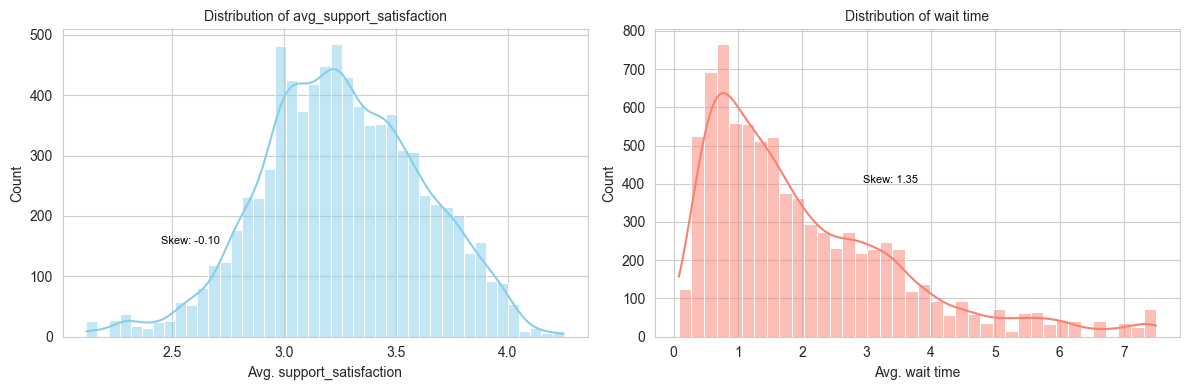

In [185]:
skew_satisfaction = grouped_df['avg_support_satisfaction'].skew()
skew_time = grouped_df['avg_wait_time'].skew()

# Set the style of seaborn
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Apply transformations
sns.histplot(grouped_df['avg_support_satisfaction'], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribution of avg_support_satisfaction', fontsize=10)
ax[0].set_xlabel('Avg. support_satisfaction')

ax[0].text(0.3, 0.3, f'Skew: {skew_satisfaction:.2f}', transform=ax[0].transAxes,
           horizontalalignment='right', color='black', fontsize=8)
 
sns.histplot(grouped_df['avg_wait_time'], kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Distribution of wait time', fontsize=10)
ax[1].set_xlabel('Avg. wait time')

ax[1].text(0.5, 0.5, f'Skew: {skew_time:.2f}', transform=ax[1].transAxes,
           horizontalalignment='right', color='black', fontsize=8)
 
plt.tight_layout()
plt.show()

In [186]:
# Apply transformations to avg_support_satisfaction
print(f"Original Skewness: {grouped_df['avg_support_satisfaction'].skew():.5f}")

# Log Transformation
grouped_df['log_avg_support_satisfaction'] = np.log(grouped_df['avg_support_satisfaction'] + 1)  # Add 1 to handle zero values if any
print(f"Skewness after Log Transformation: {grouped_df['log_avg_support_satisfaction'].skew():.5f}")

# Box-Cox Transformation (requires strictly positive values)
grouped_df['BoxCox_avg_support_satisfaction'], _ = boxcox(grouped_df['avg_support_satisfaction'] + 1)  # Add 1 to ensure positivity
print(f"Skewness after Box-Cox Transformation: {grouped_df['BoxCox_avg_support_satisfaction'].skew():.5f}")

# Yeo-Johnson Transformation (handles zero and negative values)
grouped_df['YeoJohnson_avg_support_satisfaction'], _ = yeojohnson(grouped_df['avg_support_satisfaction'])
print(f"Skewness after Yeo-Johnson Transformation: {grouped_df['YeoJohnson_avg_support_satisfaction'].skew():.5f}")

# Quantile Transformation
qt = QuantileTransformer(output_distribution='normal', random_state=0)
grouped_df['Quantile_avg_support_satisfaction'] = qt.fit_transform(grouped_df[['avg_support_satisfaction']])
print(f"Skewness after Quantile Transformation: {grouped_df['Quantile_avg_support_satisfaction'].skew():.5f}") # best performant so far


Original Skewness: -0.10252
Skewness after Log Transformation: -0.36353
Skewness after Box-Cox Transformation: -0.00463
Skewness after Yeo-Johnson Transformation: -0.00463
Skewness after Quantile Transformation: -0.07964


In [187]:
# Apply transformations to avg_wait_time
print(f"Original Skewness: {grouped_df['avg_wait_time'].skew():.5f}")

# Log Transformation
grouped_df['log_avg_wait_time'] = np.log(grouped_df['avg_wait_time'] + 1)  # Add 1 to handle zero values if any
print(f"Log Skewness: {grouped_df['log_avg_wait_time'].skew():.5f}")

# Box-Cox Transformation (requires strictly positive values)
grouped_df['boxcox_avg_wait_time'], _ = stats.boxcox(grouped_df['avg_wait_time'])
print(f"Box-Cox Skewness: {grouped_df['boxcox_avg_wait_time'].skew():.5f}")

# Yeo-Johnson Transformation (handles zero and negative values)
grouped_df['yeojohnson_avg_wait_time'], _ = stats.yeojohnson(grouped_df['avg_wait_time'])
print(f"Yeo-Johnson Skewness: {grouped_df['yeojohnson_avg_wait_time'].skew():.5f}")

# Quantile Transformation
qt = QuantileTransformer(output_distribution='normal', random_state=0)
grouped_df['quantile_avg_wait_time'] = qt.fit_transform(grouped_df[['avg_wait_time']])
print(f"Quantile Skewness: {grouped_df['quantile_avg_wait_time'].skew():.5f}") # best performant so far

Original Skewness: 1.34508
Log Skewness: 0.38962
Box-Cox Skewness: -0.01931
Yeo-Johnson Skewness: 0.05612
Quantile Skewness: 0.27937


Vizualization after transformations


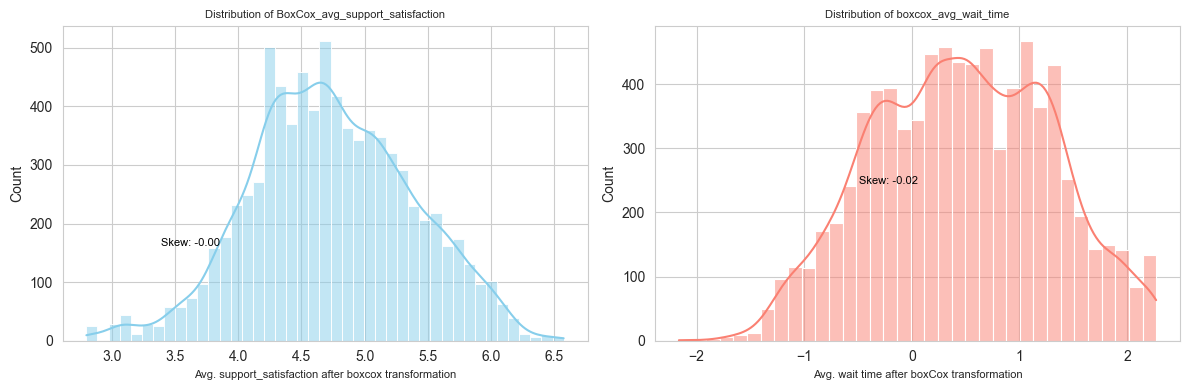

In [188]:
skew_satisfaction = grouped_df['BoxCox_avg_support_satisfaction'].skew()
skew_time = grouped_df['boxcox_avg_wait_time'].skew()

# Set the style of seaborn
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Apply transformations
sns.histplot(grouped_df['BoxCox_avg_support_satisfaction'], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Distribution of BoxCox_avg_support_satisfaction', fontsize=8)
ax[0].set_xlabel('Avg. support_satisfaction after boxcox transformation', fontsize=8)

ax[0].text(0.3, 0.3, f'Skew: {skew_satisfaction:.2f}', transform=ax[0].transAxes,
           horizontalalignment='right', color='black', fontsize=8)
 
sns.histplot(grouped_df['boxcox_avg_wait_time'], kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Distribution of boxcox_avg_wait_time', fontsize=8)
ax[1].set_xlabel('Avg. wait time after boxCox transformation', fontsize=8)

ax[1].text(0.5, 0.5, f'Skew: {skew_time:.2f}', transform=ax[1].transAxes,
           horizontalalignment='right', color='black', fontsize=8)
 
plt.tight_layout()
plt.show()

In [189]:
grouped_df.columns

Index(['created_date', 'response_id_count', 'avg_support_satisfaction',
       'avg_wait_time', 'wait_time_in_days', 'avg_wait_csat', 'csat_reduction',
       'csat_reduction_percentage', 'log_avg_support_satisfaction',
       'BoxCox_avg_support_satisfaction',
       'YeoJohnson_avg_support_satisfaction',
       'Quantile_avg_support_satisfaction', 'log_avg_wait_time',
       'boxcox_avg_wait_time', 'yeojohnson_avg_wait_time',
       'quantile_avg_wait_time'],
      dtype='object')

In [190]:
df3 = grouped_df[['created_date', 'response_id_count', 'BoxCox_avg_support_satisfaction', 'boxcox_avg_wait_time']]
df3.head()

,created_date,response_id_count,BoxCox_avg_support_satisfaction,boxcox_avg_wait_time
0,2021-10-17,5,3.252063,-2.163683
1,2021-10-18,44,4.708188,-1.251031
2,2021-10-18,44,4.708188,-1.251031
3,2021-10-19,73,4.064536,-0.821808
4,2021-10-19,73,4.064536,-0.821808


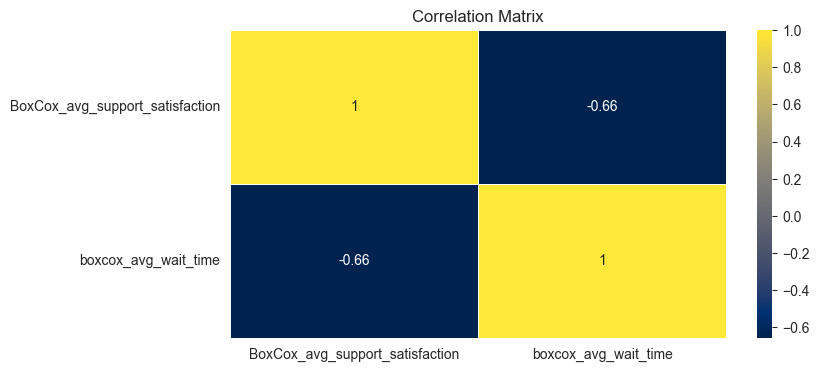

,BoxCox_avg_support_satisfaction,boxcox_avg_wait_time
BoxCox_avg_support_satisfaction,1.000000,-0.657346
boxcox_avg_wait_time,-0.657346,1.000000


In [191]:
corr = df3[['BoxCox_avg_support_satisfaction', 'boxcox_avg_wait_time']].corr()

plt.figure(figsize=(8, 4))
sns.heatmap(corr, annot=True, cmap='cividis', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()
corr

There’s a  negative correlation between support satisfaction and wait time. As `avg_wait_time` increases, `avg_support_satisfaction` tends to decrease.

In [192]:
df3.sort_values('response_id_count')

,created_date,response_id_count,BoxCox_avg_support_satisfaction,boxcox_avg_wait_time
0,2021-10-17,5,3.252063,-2.163683
543,2021-12-26,23,3.633826,-0.119918
542,2021-12-26,23,3.633826,-0.119918
541,2021-12-26,23,3.633826,-0.119918
540,2021-12-26,23,3.633826,-0.119918
...,...,...,...,...
7061,2024-11-14,286,3.946188,1.327024
7060,2024-11-14,286,3.946188,1.327024
7059,2024-11-14,286,3.946188,1.327024
7068,2024-11-14,286,3.946188,1.327024


In [193]:
# Compute rolling correlation
grouped_df['rolling_corr'] = df3['BoxCox_avg_support_satisfaction'].rolling(window=7).corr(grouped_df['boxcox_avg_wait_time'])

# Find the date with the strongest inverse correlation
strongest_inverse_date = grouped_df.loc[grouped_df['rolling_corr'].idxmin(), 'created_date']
print(f"Strongest inverse correlation observed on: {strongest_inverse_date}")
highlighted_point = grouped_df.loc[grouped_df['created_date'] == strongest_inverse_date]

Strongest inverse correlation observed on: 2023-10-22 00:00:00


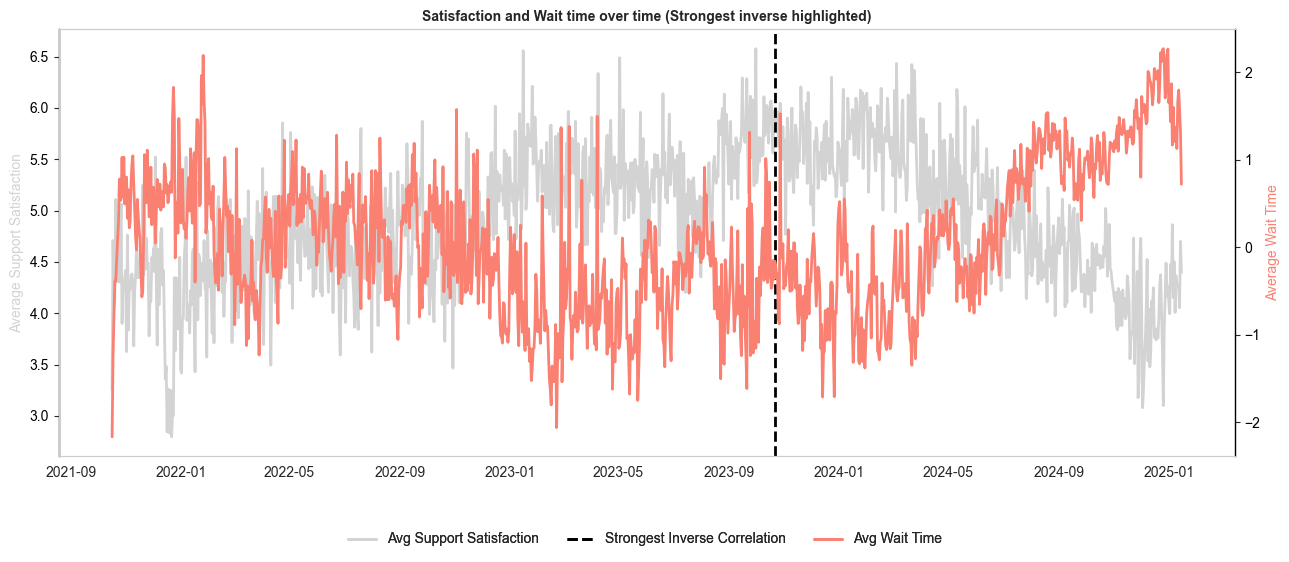

In [194]:
fig, ax1 = plt.subplots(figsize=(13, 5))

# Plot avg_support_satisfaction on the first y-axis

ax1.set_ylabel('Average Support Satisfaction', color='lightgrey', fontsize=10)
ax1.plot(grouped_df['created_date'], df3['BoxCox_avg_support_satisfaction'], color='lightgrey', label='Avg Support Satisfaction', linewidth=2)
ax1.tick_params(axis='y', labelcolor='black')
ax1.spines['left'].set_color('black')
ax1.spines['left'].set_linewidth(1)

ax2 = ax1.twinx()
ax2.set_ylabel('Average Wait Time', color='salmon', fontsize=10)
ax2.plot(grouped_df['created_date'], df3['boxcox_avg_wait_time'], color='salmon', label='Avg Wait Time', linewidth=2)
ax2.tick_params(axis='y', labelcolor='black')
ax2.spines['right'].set_color('black')
ax2.spines['right'].set_linewidth(1)

ax1.axvline(x=strongest_inverse_date, color='black', linestyle='--', linewidth=2, label='Strongest Inverse Correlation')

ax1.grid(False)
ax2.grid(False)

plt.xticks(rotation=45)

fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=10, frameon=False)
plt.title('Satisfaction and Wait time over time (Strongest inverse highlighted)', fontsize=10, fontweight='bold')
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

fig.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=10, frameon=False)
plt.show()


Intercept: 4.51729233146108
Coefficients: [-0.85697451]
R^2: 0.40647357803907735


Text(0.5, 1.0, 'Linear Regression avg_support_satisfaction vs avg_wait_time')

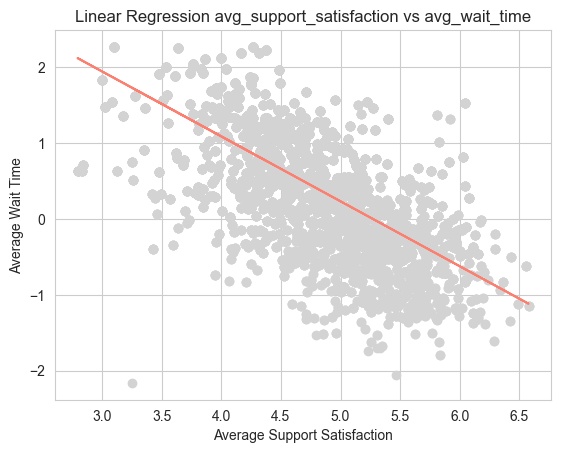

In [195]:
# Linerar Regression
X = df3[['BoxCox_avg_support_satisfaction']]
y = df3['boxcox_avg_wait_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

print('Intercept:', lr.intercept_)
print("Coefficients:", lr.coef_)
print("R^2:", lr.score(X_test, y_test))

# Plotting the regression line
plt.scatter(X, y, color='lightgrey', label='Data Points')
plt.plot(X, lr.predict(X), color='salmon', label='Regression Line')
plt.xlabel('Average Support Satisfaction')
plt.ylabel('Average Wait Time')
plt.title('Linear Regression avg_support_satisfaction vs avg_wait_time')


The model suggests an inverse relationship between satisfaction and wait time, but the low R² value indicates that the model doesn't explain a large proportion of the variance, meaning there may be other significant factors influencing the wait time that are not captured in this simple model.

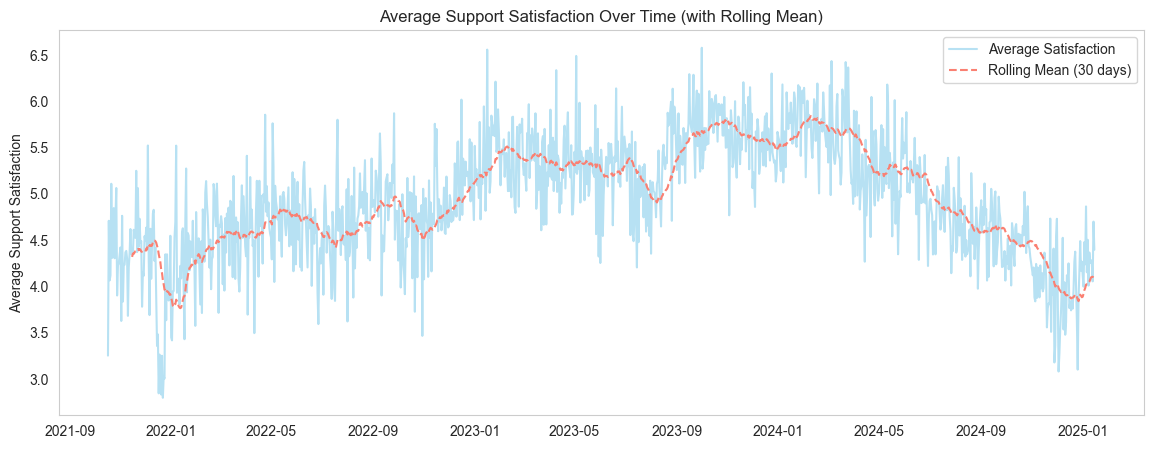

In [196]:
df4 = df3.groupby('created_date')['BoxCox_avg_support_satisfaction'].mean()

# rolling mean (e.g., window of 30 days)
rolling_mean = df4.rolling(window=30).mean()

plt.figure(figsize=(14, 5))
plt.plot(df4, label='Average Satisfaction', color='skyblue', alpha=0.6)
plt.plot(rolling_mean, label='Rolling Mean (30 days)', color='salmon', linestyle='--')
plt.title('Average Support Satisfaction Over Time (with Rolling Mean)')
plt.ylabel('Average Support Satisfaction')
plt.legend()
plt.grid(False)

plt.show()

In [197]:
from scipy.stats import pearsonr
corr, p_value = pearsonr(df3['BoxCox_avg_support_satisfaction'], df3['boxcox_avg_wait_time'])
print(f"Pearson Correlation: {corr}, P-value: {p_value}")

# If the p-value is <0.05, the correlation is statistically significant.

Pearson Correlation: -0.657346257296779, P-value: 0.0


**Insights**
- Perason correlation Indicates a moderate negative linear relationship between the two variables.
- As one variable increases, the other tends to decrease.
- The negative correlation observed (-0.61) is highly statistically significant.

In [198]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(grouped_df[['BoxCox_avg_support_satisfaction', 'boxcox_avg_wait_time']], maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=116.0584, p=0.0000  , df_denom=8091, df_num=1
ssr based chi2 test:   chi2=116.1015, p=0.0000  , df=1
likelihood ratio test: chi2=115.2767, p=0.0000  , df=1
parameter F test:         F=116.0584, p=0.0000  , df_denom=8091, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=58.0364 , p=0.0000  , df_denom=8088, df_num=2
ssr based chi2 test:   chi2=116.1445, p=0.0000  , df=2
likelihood ratio test: chi2=115.3190, p=0.0000  , df=2
parameter F test:         F=58.0364 , p=0.0000  , df_denom=8088, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=40.1617 , p=0.0000  , df_denom=8085, df_num=3
ssr based chi2 test:   chi2=120.5894, p=0.0000  , df=3
likelihood ratio test: chi2=119.6997, p=0.0000  , df=3
parameter F test:         F=40.1617 , p=0.0000  , df_denom=8085, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=31.2516 , p=0.

{np.int64(1): ({'ssr_ftest': (np.float64(116.05843538513261),
    np.float64(7.019188425167287e-27),
    np.float64(8091.0),
    np.int64(1)),
   'ssr_chi2test': (np.float64(116.10146780463027),
    np.float64(4.5159016615862014e-27),
    np.int64(1)),
   'lrtest': (np.float64(115.27665806091682),
    np.float64(6.844979101477813e-27),
    np.int64(1)),
   'params_ftest': (np.float64(116.05843538514624),
    np.float64(7.019188425115667e-27),
    np.float64(8091.0),
    1.0)},
   array([[0., 1., 0.]])]),
 np.int64(2): ({'ssr_ftest': (np.float64(58.036381875523716),
    np.float64(9.424713918296994e-26),
    np.float64(8088.0),
    np.int64(2)),
   'ssr_chi2test': (np.float64(116.14451991063636),
    np.float64(6.019188577991545e-26),
    np.int64(2)),
   'lrtest': (np.float64(115.31900021571346),
    np.float64(9.094886295187857e-26),
    np.int64(2)),
   'params_ftest': (np.float64(58.036381875528924),
    np.float64(9.424713918254001e-26),
    np.float64(8088.0),
    2.0)},
   array(

**Summary:**
There is a short-term Granger causality (up to lag 6) between the variables.


The VAR (Vector Autoregression) order selection results indicate that the optimal lag order depends on the selection criterion:

In [199]:
from statsmodels.tsa.api import VAR
model = VAR(grouped_df[['Quantile_avg_support_satisfaction', 'quantile_avg_wait_time']])
selected_lags = model.select_order(maxlags=15)
print(selected_lags.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0      -0.4656     -0.4639      0.6277     -0.4650
1       -5.211      -5.206    0.005455      -5.209
2       -5.213      -5.204    0.005447      -5.210
3       -5.214      -5.202    0.005441      -5.210
4       -5.215      -5.200    0.005432      -5.210
5       -5.234      -5.215    0.005330      -5.228
6       -5.241     -5.219*    0.005294      -5.233
7       -5.244      -5.218    0.005281      -5.235
8       -5.245      -5.216    0.005272      -5.235
9       -5.248      -5.215    0.005257      -5.237
10      -5.249      -5.212    0.005254      -5.236
11      -5.251      -5.211    0.005242      -5.237
12      -5.253      -5.210    0.005232      -5.238
13      -5.254      -5.207    0.005225      -5.238
14      -5.255      -5.205    0.005219      -5.238
15     -5.258*      -5.204   0.005208*     -5.239*
-------------------------------

**The VAR results confirm that:**

Customer satisfaction is influenced by wait times over multiple preceding days.
This supports your finding that longer wait times (beyond 6 days) lead to significantly lower satisfaction, with a time window of influence spanning 5-15 days depending on the criterion.


### 2. Quantifying the impact of wait times on satisfaction scores

In [ ]:
# Filter the baseline avg_wait_csat for '<2 days'
baseline_csat = avg_csat.loc[avg_csat['wait_time_category'] == '<2 days', 'avg_csat'].values[0]

# Calculate the reduction in satisfaction for each category
avg_csat['csat_reduction'] = baseline_csat - avg_csat['avg_wait_csat']
avg_csat['csat_reduction_percentage'] = (avg_csat['csat_reduction'] / baseline_csat) * 100

print(avg_csat[['wait_time_category', 'avg_csat', 'csat_reduction', 'csat_reduction_percentage']])

- Overall, these results indicate a clear negative correlation between longer wait times and lower customer satisfaction, with a steeper decline in satisfaction for waits exceeding 6 days.

- Customers who wait <2 days have the highest satisfaction csat scores.
Satisfaction drops significantly as wait times increase, with the steepest drop (>30%) for wait times longer than 6 days.

### Version 2

In [217]:
grouped_df.sort_values(by='created_date', ascending=True)
grouped_df

,created_date,wait_time_in_days,response_id_count,avg_support_satisfaction,avg_wait_time,avg_csat
0,2021-10-17,0,5,0.480000,0.082843,0.716801
1,2021-10-18,0,42,0.654762,0.213152,0.716801
2,2021-10-18,1,2,0.550000,1.218466,0.632573
3,2021-10-19,0,63,0.615873,0.279523,0.716801
4,2021-10-19,1,10,0.330000,1.316993,0.632573
...,...,...,...,...,...,...
8090,2025-01-15,3,6,0.333333,3.489182,0.555415
8091,2025-01-15,4,1,0.200000,4.856007,0.537262
8092,2025-01-15,5,1,0.200000,5.155521,0.525350
8093,2025-01-15,6,5,0.480000,6.440431,0.512687


In [218]:
# convert wait_time_in_days in int
grouped_df['wait_time_in_days'] = grouped_df['wait_time_in_days'].astype(int)
grouped_df

,created_date,wait_time_in_days,response_id_count,avg_support_satisfaction,avg_wait_time,avg_csat
0,2021-10-17,0,5,0.480000,0.082843,0.716801
1,2021-10-18,0,42,0.654762,0.213152,0.716801
2,2021-10-18,1,2,0.550000,1.218466,0.632573
3,2021-10-19,0,63,0.615873,0.279523,0.716801
4,2021-10-19,1,10,0.330000,1.316993,0.632573
...,...,...,...,...,...,...
8090,2025-01-15,3,6,0.333333,3.489182,0.555415
8091,2025-01-15,4,1,0.200000,4.856007,0.537262
8092,2025-01-15,5,1,0.200000,5.155521,0.525350
8093,2025-01-15,6,5,0.480000,6.440431,0.512687


In [219]:
aggregated_days_15 = grouped_df.groupby('wait_time_in_days').agg(avg_csat=('avg_csat', 'mean')).reset_index()
aggregated_days_15.sort_values(by='wait_time_in_days', ascending=True)
aggregated_days_15

,wait_time_in_days,avg_csat
0,0,0.716801
1,1,0.632573
2,2,0.594885
3,3,0.555415
4,4,0.537262
...,...,...
90,188,0.200000
91,197,0.200000
92,217,1.000000
93,247,0.200000


In [220]:
# Calculate DoD CSAT reduction as an absolute unit
aggregated_days_15['day_over_day_csat_drop'] = aggregated_days_15['avg_csat'].diff(-1).fillna(0)
aggregated_days_15['day_over_day_csat_drop'] = aggregated_days_15['day_over_day_csat_drop'].apply(lambda x: f'{x *100:.2f}%')
aggregated_days_15['avg_csat'] = aggregated_days_15['avg_csat'].apply(lambda x: f'{x *100:.2f}%')

aggregated_days_15.loc[:15]

,wait_time_in_days,avg_csat,day_over_day_csat_drop
0,0,71.68%,8.42%
1,1,63.26%,3.77%
2,2,59.49%,3.95%
3,3,55.54%,1.82%
4,4,53.73%,1.19%
5,5,52.54%,1.27%
6,6,51.27%,1.02%
7,7,50.25%,3.93%
8,8,46.31%,0.67%
9,9,45.64%,-0.86%
